# General Setup

In [2]:
%matplotlib widget

from pyCascade import probePost, physics, utils
from matplotlib import pyplot as plt
import numpy as np
import os

category =  "single_family"



In [3]:
############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)

'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

'/Users/nicholasbachand/Documents/Research/Cascade/city_block_cfd'

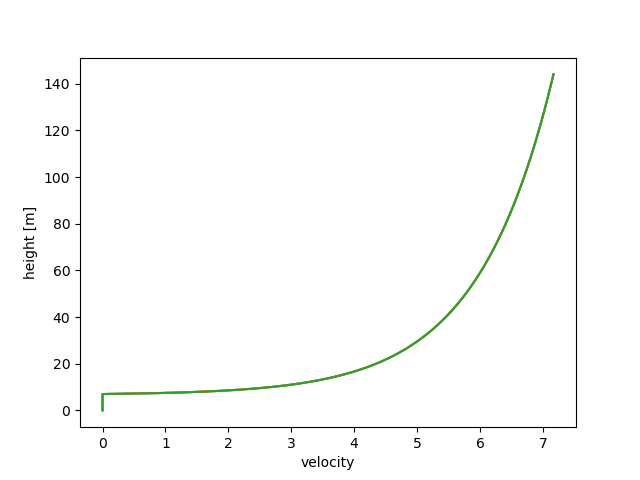

In [4]:
vK_const = 0.4
hm = 6
rho = 1.225
mu = 1.7894e-5
# Re_tau = 43300
Lz =  24*hm
z_ref = 10 # really y_ref
U_ref = 4

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = vK_const*U_ref/np.log(z_ref/z_0)

LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'vK_const': vK_const,
    'Dt': .01,
    'z_values' : np.linspace(0,Lz,Lz*10)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

# physics_setup.plot_log_wind()

plt.plot(ux, LES_params['z_values'])
plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [4]:
physics_setup.plot_spinup_velocity()

u_bulk is 5.686382916184899
domain height is 144.0


In [5]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )


U infinity is 7.168206228236349 with L = 144.0
flat plate Reynolds number is 70606871.40740058
wall spacing is 0.03251964367353289 for y+ of 500


In [5]:
# NEED TO EXTRACT BETTER NORMALIZING CONSTANT
physics_setup.LES_params['uStar']
physics_setup.LES_params['z_values'][330]
physics_setup.LES_params['log_wind'][330]



5.172260845042926

In [6]:
window_dim = hm/2/4

velocity_scaling = 1/physics_setup.LES_params['log_wind'][330]
ventilation_scaling = velocity_scaling/(window_dim**2)
                                        
norm_vel = utils.dict_apply(lambda data_df : data_df*velocity_scaling)
norm_vent = utils.dict_apply(lambda data_df : data_df*velocity_scaling)
abs_values = utils.dict_apply(lambda df : df.abs())

# Run

In [7]:
run = 15
qois = ['comp(u,0)', 'comp(u,2)']

In [9]:
# from dask import dataframe as dd
# import time
# path = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut/col_3-2.comp(u,0)'

# ddf = dd.read_csv(path, delimiter = ' ', comment = "#",header = None)
# new_index = ddf.iloc[:, 1] #grab the second row for the header
# ddf = ddf.iloc[:, 3:] #take the data less the header row
# ddf.index = new_index #set the header row as the df header

# _, n_cols = ddf.shape
# ddf = ddf.rename(columns=dict(zip(ddf.columns, np.arange(0, n_cols))))

In [10]:
# import pyarrow as ar
# from pyarrow import csv, cpu_count
# import time

# def skip_comment(row):
#     if row.text.startswith("# "):
#         return 'skip'
#     else:
#         return 'error'

# def read_probes(filename):
# #     ar.set_io_thread_count(36)
# #     ar.io_thread_count()
# #     ar.set_cpu_count(36)
#     print(f"Pyarrow reading PROBE file on {cpu_count()} threads")
#     read_options = csv.ReadOptions(skip_rows = 5, autogenerate_column_names = True, use_threads = True, block_size = 1e7)
#     parse_options = csv.ParseOptions(delimiter=" ", invalid_row_handler=skip_comment)
#     pyarrow_table = csv.read_csv(filename, read_options, parse_options)
#     df = pyarrow_table.to_pandas()
#     df = df.transpose()
#     new_header = df.iloc[1] #grab the second row for the header
#     df = df[3:].reset_index(drop=True) #take the data less the header row
#     df.columns = new_header #set the header row as the df header
#     return df.stack().to_dict()  # save as tuple indexed dictionary

# ar.io_thread_count()
# ar.cpu_count()

In [11]:
# start = time.time()
# data = read_probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut/col_3-2.comp(u,0)')
# end = time.time()
# print(end-start)

In [8]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

In [13]:
# ## 10 m flow statistics
# ref_flow = probes.statistics(
#     names = [name for name in  probes.probe_names if "col" in name], 
#     steps = probes.probe_steps[0:-1:1],
#     quants = ['comp(u,0)','comp(u,2)' ],
#     stack = probes.probe_stack[11],
#     processing = [probePost.time_average],
#     parrallel=True
#     )

In [14]:
# ref_flow.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/10m_flow')

processing data took 0 seconds
plotting took 0 seconds


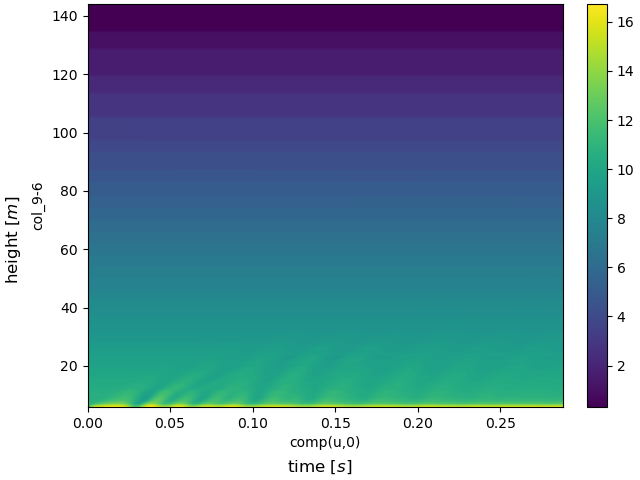

In [8]:
norm_data = lambda data_df : data_df*ventilation_scaling

plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : 1,
    'stack span' : 'y',
    'xlabel': 'time $[s]$',
    'ylabel' : r'height $[m]$',
    # 'ColorNorm': 'Centered',
    'veritcal scaling' : 1
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = ['col_9-6'],#[name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[:-10:1],
    quants = ['comp(u,0)'],#'comp(u,1)','comp(u,2)', 'p'],
    parrallel = True,
    plot_params = plot_params
#     processing = [norm_vel]
    )

plt.show()

In [16]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_history')

processing data took 0 seconds


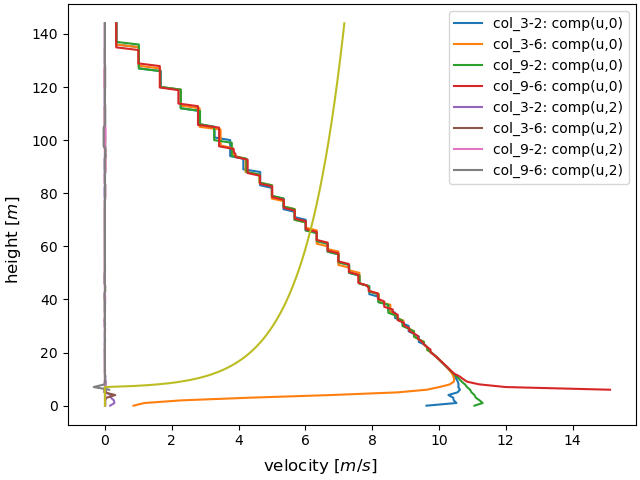

In [9]:
probes.profile_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[::],
    quants = qois,
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'velocity $[m/s]$',
        'ylabel' : r'height $[m]$',
        'veritcal scaling' : 1
        },
    parrallel=True,
    processing = [probePost.time_average]
    )

plt.plot(physics_setup.LES_params['log_wind'], LES_params['z_values'])

In [18]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

processing data took 1 seconds
plotting took 1 seconds


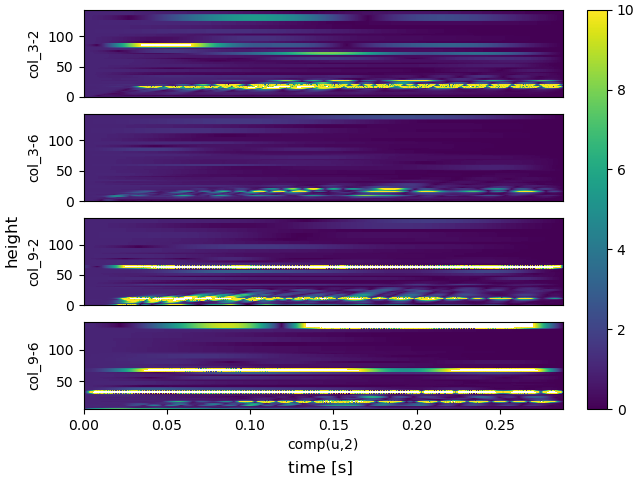

In [10]:
plot_params = {
    'plot_levels' : {
        'comp(u,0)' : np.linspace(0,10,200),
        'comp(u,1)' : np.linspace(0,10,200),
        'comp(u,2)' : np.linspace(0,10,200)
    },
    'horizontal spacing' : 1,
    'stack span' : 'y',
    'xlabel': 'time [s]',
    'ylabel' : 'height',
    'plot_every': 1
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[:-10:1],
    quants = ['comp(u,2)'],
    parrallel = True,
    processing = [probePost.mean_convergence],
    plot_params = plot_params
    )

In [ ]:
# plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_convergence')

## X Flow


processing data took 0 seconds
processing data took 0 seconds
processing data took 0 seconds
processing data took 0 seconds


,"comp(u,0)"
xwindow_0-0,8.637956
xwindow_0-1,8.390959
xwindow_2-0,2.479880
xwindow_2-1,2.639693


,"comp(u,0)"
xwindow_0-0,10.690229
xwindow_0-1,10.611237
xwindow_2-0,11.949952
xwindow_2-1,11.683692


,"comp(u,0)"
xwindow_0-0,9.200602
xwindow_0-1,8.976429
xwindow_2-0,5.986635
xwindow_2-1,5.894571


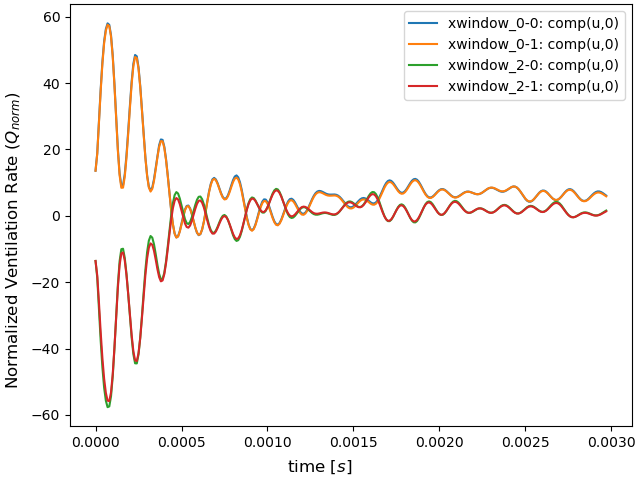

In [9]:
start = -10000
stop = -1
by = 1

norm_norm = lambda df : probePost.mul_names(df, ['xwindow_2-0', 'xwindow_2-1'], -1)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, norm_norm],
    parrallel=True
    )

## mean statistics
x_mean = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
x_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
x_net = probes.statistics(
    names = [name for name in  probes.probe_names if "xwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, abs_values, probePost.time_average],
    parrallel=False
    )


display(x_mean)
display(x_rms)
display(x_net)

In [11]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/xwindows')

x_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xmean.csv')
x_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xrms.csv')
x_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/xnet.csv')

## Z Flow


processing data took 0 seconds
processing data took 0 seconds
processing data took 0 seconds
processing data took 0 seconds


,"comp(u,2)"
zwindow_0-0,0.820857
zwindow_0-1,-0.826363
zwindow_1-0,-0.564439
zwindow_1-1,0.583547
zwindow_2-0,-2.583743
zwindow_2-1,2.669708


,"comp(u,2)"
zwindow_0-0,6.108096
zwindow_0-1,6.273669
zwindow_1-0,1.995277
zwindow_1-1,2.023255
zwindow_2-0,5.930638
zwindow_2-1,5.978675


,"comp(u,0)"
zwindow_0-0,10.092664
zwindow_0-1,10.133208
zwindow_1-0,8.224176
zwindow_1-1,8.275917
zwindow_2-0,4.318496
zwindow_2-1,4.374827


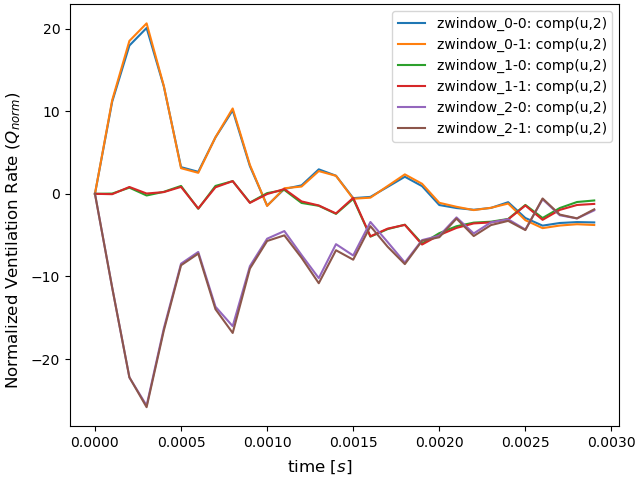

In [12]:
start = -10000
stop = -1
by = 10

norm_norm = lambda df : probePost.mul_names(df, ['zwindow_0-1', 'zwindow_1-1', 'zwindow_2-1'], -1)

(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'Normalized Ventilation Rate ($Q_{norm}$)',
        'xlabel' : 'time $[s]$',
        'horizontal spacing' : physics_setup.LES_params['Dt'],
        },
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, norm_norm],
    parrallel=True
    )

## mean statistics
z_mean = ventilation_scaling * probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

## rms statistics
z_rms = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,2)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

## Net flow
z_net = probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[start:stop:by],
    quants = ['comp(u,0)'],
    processing = [norm_vent, probePost.ClenshawCurtis_Quadrature, abs_values, probePost.time_average],
    parrallel=False
    )

display(z_mean)
display(z_rms)
display(z_net)

In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/zwindows')

z_mean.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zmean.csv')
z_rms.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/zrms.csv')
z_net.to_csv(f'{home_dir}/CHARLES/{category}/R{run}/tables/znet.csv')

## Other Post Processing

processing data took 0 seconds


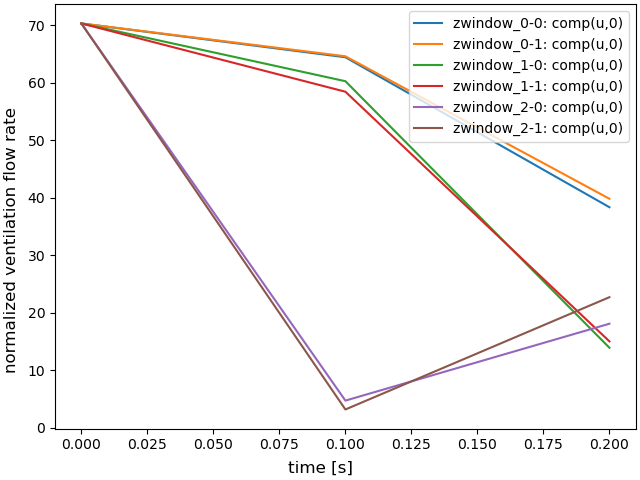

In [13]:
(fig, ax) = probes.time_plots(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:100],
    quants = ['comp(u,0)'],
    plot_params = {
        'stack span' : 'y',
        'ylabel': 'normalized ventilation flow rate',
        'xlabel' : 'time [s]',
        'qoi_scaling' : 1/1.0625
        },
    processing = [probePost.ClenshawCurtis_Quadrature],
    parrallel=True
    )

In [14]:
## mean statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    processing = [probePost.ClenshawCurtis_Quadrature, probePost.time_average],
    parrallel=False
    )

processing data took 0 seconds


,"comp(u,0)"
zwindow_0-0,51.655813
zwindow_0-1,51.851315
zwindow_1-0,42.154124
zwindow_1-1,42.399795
zwindow_2-0,21.633364
zwindow_2-1,21.855965


In [15]:
## rms statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "zwindow" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    processing = [probePost.ClenshawCurtis_Quadrature, probePost.time_rms],
    parrallel=False
    )

processing data took 0 seconds


,"comp(u,0)"
zwindow_0-0,22.937151
zwindow_0-1,23.278807
zwindow_1-0,17.132101
zwindow_1-1,16.876836
zwindow_2-0,9.997424
zwindow_2-1,10.858135


In [ ]:
# probes.probe_stack

In [16]:
## 10 m flow statistics
probes.statistics(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-10000:-1:1],
    quants = ['comp(u,0)'],
    stack = probes.probe_stack[33],
    processing = [probePost.time_average],
    parrallel=True
    )

processing data took 0 seconds


,"comp(u,0)"
col_3-2,8.688550
col_3-6,8.748898
col_9-2,8.743019
col_9-6,8.361142


In [ ]:
video_dir = f'{home_dir}/CHARLES/{category}/R{run}/Videos'
video_series = "u_y2"

!pwd
!echo "saving videos to: "
%cd $video_dir
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y2". --dt .1 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y5". --dt 2 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y8". --dt 2 --subsample 1
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y20". --dt 2 --subsample 1
!echo "returning to: "
%cd -